In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize

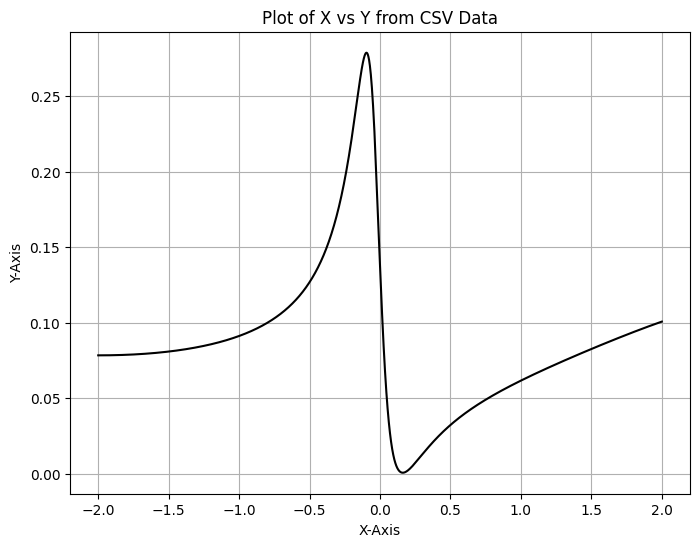

In [2]:
df = pd.read_csv('black_curve.csv')
x_values = df['xx']
y_values = df['yy']

# --- Step 4: Create the plot using matplotlib ---
plt.figure(figsize=(8, 6)) # Create a figure with a specific size
plt.plot(x_values, y_values, linestyle='-', color='black')

# --- Step 5: Add labels, a title, and a grid for clarity ---
plt.title('Plot of X vs Y from CSV Data')
plt.xlabel('X-Axis')
plt.ylabel('Y-Axis')
plt.grid(True)

# --- Step 6: Display the plot ---
plt.show()

[Adam] Epoch 0, Loss = 2.157807e-04
[Adam] Epoch 500, Loss = 1.799739e-04
[Adam] Epoch 1000, Loss = 1.799739e-04
[Adam] Epoch 1500, Loss = 1.799739e-04
[Adam] Epoch 2000, Loss = 1.799744e-04
[Adam] Epoch 2500, Loss = 1.799743e-04
[Adam] Epoch 3000, Loss = 1.799739e-04
[Adam] Epoch 3500, Loss = 1.799740e-04
[Adam] Epoch 4000, Loss = 1.799739e-04
[Adam] Epoch 4500, Loss = 1.799856e-04

Switching to LBFGS...

Best Fit Parameters:
a = 0.078161, b = -1.617019, c = -0.025116, d = 0.089202

Goodness of Fit:
SSE      = 2.523955
R-square = 0.932318
DFE      = 14020
Adj R-sq = 0.932303
RMSE     = 0.013417


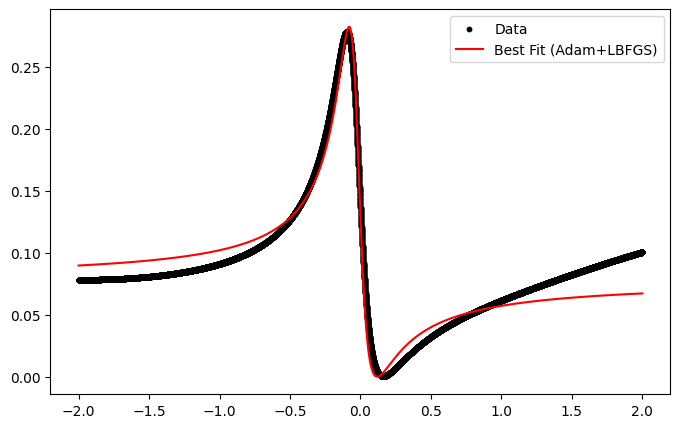

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 1. Load dataset
# =========================
df = pd.read_csv("black_curve.csv")

# Replace with actual column names
x_values = df['xx'].values  
y_values = df['yy'].values  

# Normalize X for stability
x_mean, x_std = np.mean(x_values), np.std(x_values)
x_scaled = (x_values - x_mean) / x_std

# Torch tensors
x_train_t = torch.tensor(x_scaled, dtype=torch.float32).view(-1,1)
y_train_t = torch.tensor(y_values, dtype=torch.float32).view(-1,1)

N = len(x_values)   # number of data points
p = 4               # number of parameters (a,b,c,d)

# =========================
# 2. Define parametric model
# =========================
class ParamFit(nn.Module):
    def __init__(self, a0, b0, c0, d0):
        super(ParamFit, self).__init__()
        # Trainable parameters with good initial guesses
        self.a = nn.Parameter(torch.tensor(a0, dtype=torch.float32))
        self.b = nn.Parameter(torch.tensor(b0, dtype=torch.float32))
        self.c = nn.Parameter(torch.tensor(c0, dtype=torch.float32))
        self.d = nn.Parameter(torch.tensor(d0, dtype=torch.float32))

    def forward(self, x):
        # Rescale x back to original scale
        x_orig = x * x_std + x_mean
        return (self.a*(self.b**2)/(1+((x_orig-self.c)/self.d)**2) +
                self.a*((x_orig-self.c)/self.d)**2/(1+((x_orig-self.c)/self.d)**2) +
                self.a*(2*self.b*(x_orig-self.c)/self.d)/(1+((x_orig-self.c)/self.d)**2))

# =========================
# 3. Model with initial guess
# =========================
# 👉 Replace these with MATLAB results if available
a0, b0, c0, d0 = 0.0713, -1.7316, -0.0317, 0.0946
model = ParamFit(a0, b0, c0, d0)

loss_fn = nn.MSELoss()

# =========================
# 4. Adam optimizer (warm-up)
# =========================
optimizer = optim.Adam(model.parameters(), lr=1e-3)
for epoch in range(5000):
    optimizer.zero_grad()
    y_pred = model(x_train_t)
    loss = loss_fn(y_pred, y_train_t)
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f"[Adam] Epoch {epoch}, Loss = {loss.item():.6e}")

# =========================
# 5. LBFGS optimizer (refine)
# =========================
optimizer = optim.LBFGS(model.parameters(), max_iter=5000, tolerance_grad=1e-12, tolerance_change=1e-12, history_size=100)

def closure():
    optimizer.zero_grad()
    y_pred = model(x_train_t)
    loss = loss_fn(y_pred, y_train_t)
    loss.backward()
    return loss

print("\nSwitching to LBFGS...")
optimizer.step(closure)

# =========================
# 6. Extract learned parameters
# =========================
a_fit = model.a.item()
b_fit = model.b.item()
c_fit = model.c.item()
d_fit = model.d.item()

print("\nBest Fit Parameters:")
print(f"a = {a_fit:.6f}, b = {b_fit:.6f}, c = {c_fit:.6f}, d = {d_fit:.6f}")

# =========================
# 7. Goodness-of-fit metrics
# =========================
y_pred_np = model(x_train_t).detach().numpy().flatten()
y_true_np = y_train_t.numpy().flatten()

SSE = np.sum((y_true_np - y_pred_np)**2)
SST = np.sum((y_true_np - np.mean(y_true_np))**2)
R2 = 1 - SSE/SST
DFE = N - p
Adj_R2 = 1 - (1-R2)*(N-1)/(DFE)
RMSE = np.sqrt(SSE/DFE)

print("\nGoodness of Fit:")
print(f"SSE      = {SSE:.6f}")
print(f"R-square = {R2:.6f}")
print(f"DFE      = {DFE}")
print(f"Adj R-sq = {Adj_R2:.6f}")
print(f"RMSE     = {RMSE:.6f}")

# =========================
# 8. Plot results
# =========================
plt.figure(figsize=(8,5))
plt.scatter(x_values, y_values, label="Data", s=10, color="black")
plt.plot(x_values, y_pred_np, 'r-', label="Best Fit (Adam+LBFGS)")
plt.legend()
plt.show()
